<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Collecting Failure cases for ASR</h1>

**Objective**: Collect failure cases to improve the Speech to text model.

**Model**: We are working on the `facebook/s2t-small-librispeech-asr model` which is a Speech to Text Transformer (S2T) model trained for automatic speech recognition (ASR). The S2T model was proposed in this [paper](https://arxiv.org/abs/2010.05171) and released in this [repository](https://github.com/facebookresearch/fairseq/tree/main/examples/speech_to_text)

**Dataset**: The model is trained on [LibriSpeech ASR Corpus](https://www.openslr.org/12), a dataset consisting of approximately 1000 hours of 16kHz read English speech.

**Method**: We use the faster-whisper model to identify failure cases

#### Install required packages

In [ ]:
# Installation steps: https://huggingface.co/docs/transformers/installation
# Model borrowed from: https://huggingface.co/docs/transformers/model_doc/speech_to_text
# pip install datasets
# https://github.com/google/sentencepiece#installation
# pip install soundfile librosa

In [1]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration, pipeline, AutoTokenizer, AutoModel
from datasets import load_dataset, Audio
import warnings
import pandas as pd
import numpy as np

import uptrain

warnings.simplefilter('ignore')

/Users/sourabhagrawal/miniconda3/envs/prod_dev2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define our model and datasets

In [2]:
model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
transcriber = pipeline("automatic-speech-recognition", model="facebook/s2t-small-librispeech-asr")

In [18]:
def process_dataset(dataset):
    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
    return dataset

dataset = process_dataset(load_dataset("PolyAI/minds14", name="en-US", split="train").shuffle(seed=42).train_test_split(test_size=50))['test']

Found cached dataset minds14 (/Users/sourabhagrawal/.cache/huggingface/datasets/PolyAI___minds14/en-US/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696)
Loading cached shuffled indices for dataset at /Users/sourabhagrawal/.cache/huggingface/datasets/PolyAI___minds14/en-US/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696/cache-cfa7a2ed5f85e6a7.arrow


Let's define UpTrain config. We will use Monitor.OUTPUT_COMPARISON to compare our model's output against output generated by the [Whisper model](https://github.com/guillaumekln/faster-whisper). We will use RogueL as the metric for comparison of the two model outputs. 

In [19]:
dataset

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 50
})

In [20]:
cfg = {
    "checks": [{
        'type': uptrain.Monitor.OUTPUT_COMPARISON,
        "measurable_args": {
            'type': uptrain.MeasurableType.PREDICTION,
        },
        "comparison_model": uptrain.ComparisonModel.FASTER_WHISPER,
        "comparison_metric": uptrain.ComparisonMetric.ROGUE_L_F1,
        "comparison_model_input_args": {
            "type": uptrain.MeasurableType.INPUT_FEATURE,
            "feature_name": "audio_file"
        },
        "threshold": 0.6
    }],

    "logging_args": {
        "st_logging": True
    }
}

In [21]:
framework = uptrain.Framework(cfg_dict=cfg)

for idx in range(len(dataset)):
    inputs = {"audio_file": [dataset[idx]["audio"]["path"]]}
    preds = [x['text'] for x in transcriber(inputs["audio_file"])]
    framework.log(inputs=inputs, outputs=preds)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs


objc[39885]: Class AVFFrameReceiver is implemented in both /Users/sourabhagrawal/miniconda3/envs/prod_dev2/lib/libavdevice.58.8.100.dylib (0x2a7314798) and /Users/sourabhagrawal/miniconda3/envs/prod_dev2/lib/python3.10/site-packages/av/.dylibs/libavdevice.59.7.100.dylib (0x17f530778). One of the two will be used. Which one is undefined.
objc[39885]: Class AVFAudioReceiver is implemented in both /Users/sourabhagrawal/miniconda3/envs/prod_dev2/lib/libavdevice.58.8.100.dylib (0x2a73147e8) and /Users/sourabhagrawal/miniconda3/envs/prod_dev2/lib/python3.10/site-packages/av/.dylibs/libavdevice.59.7.100.dylib (0x17f5307c8). One of the two will be used. Which one is undefined.



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8503
  Network URL: http://192.168.151.48:8503

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            


This is how the UpTrain dashboard looks like.
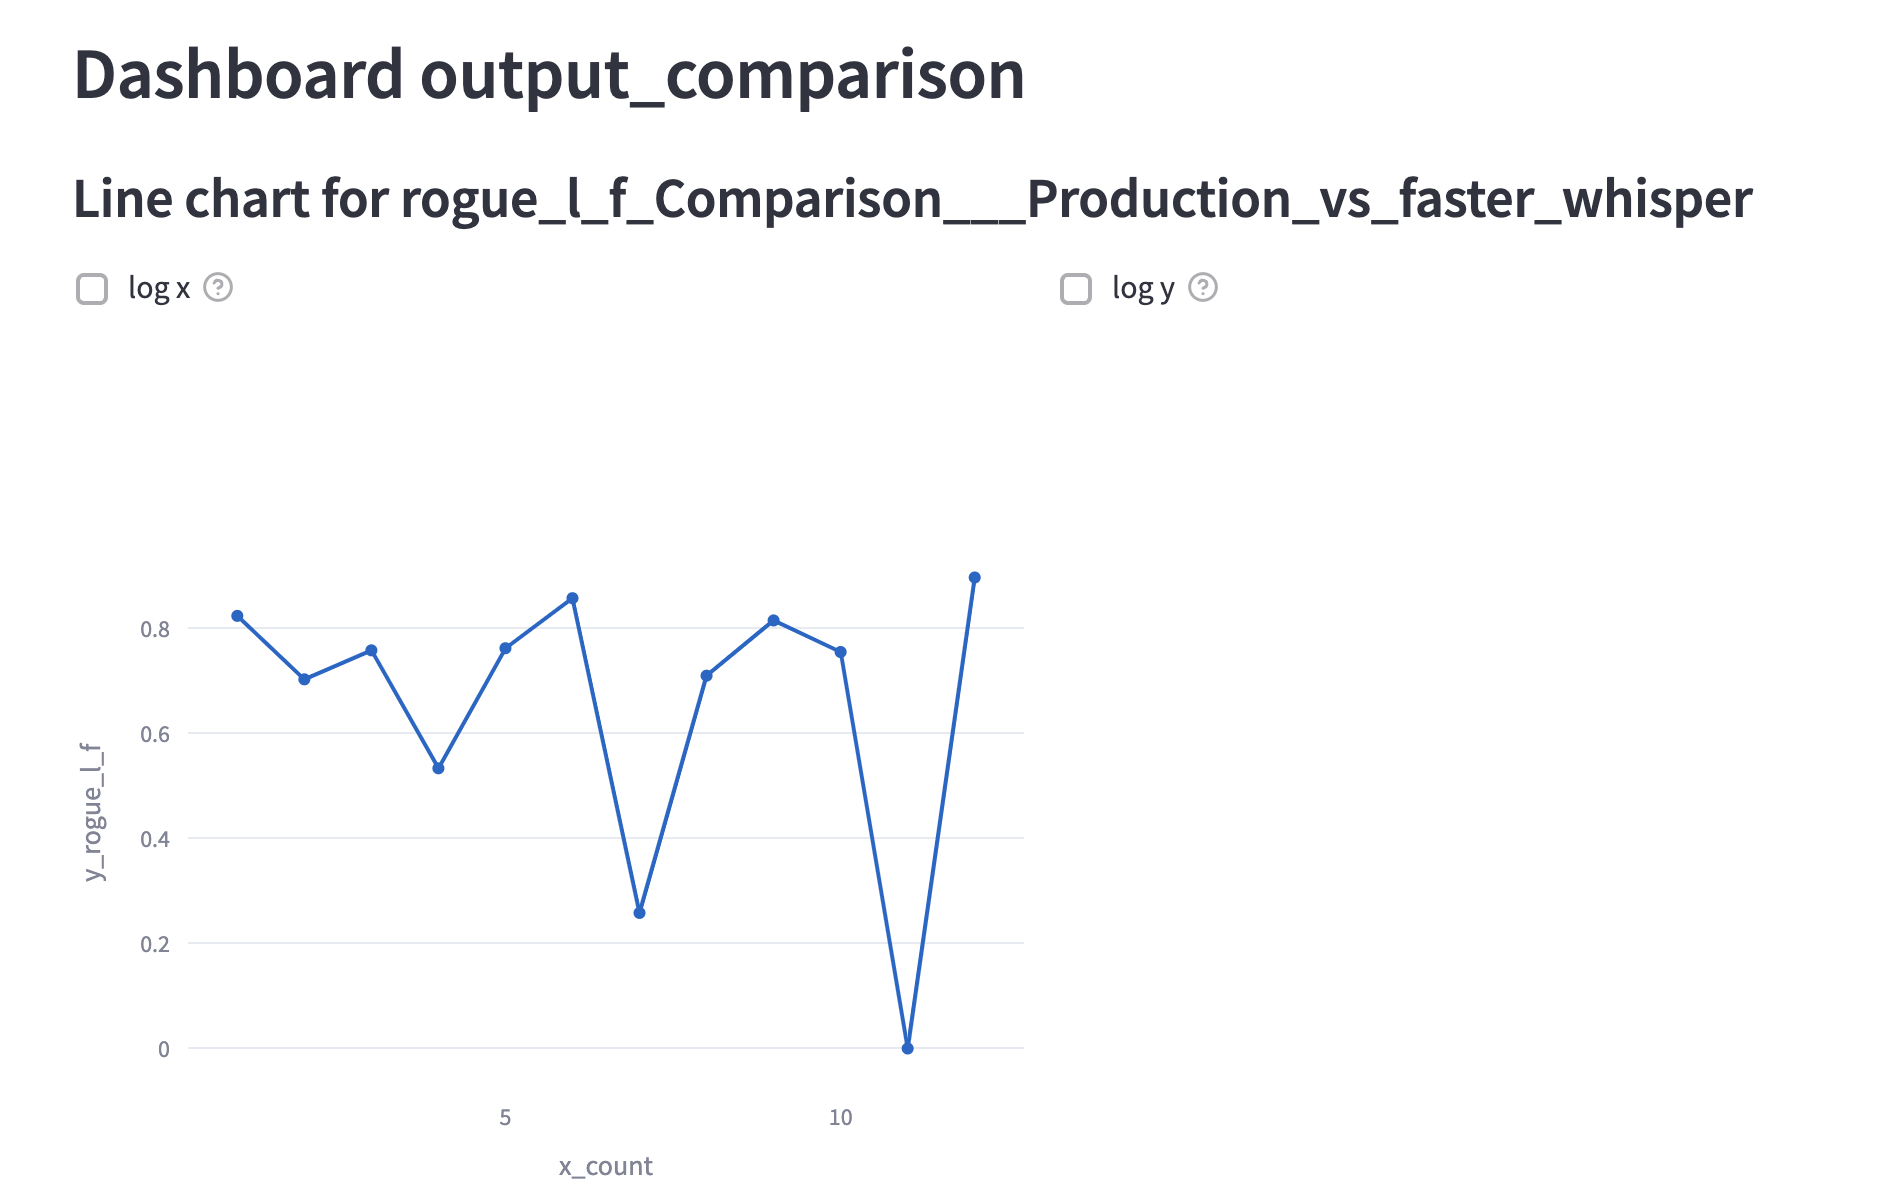

As we can see we have several cases where our model disagrees with Whisper's outputs. Let's see what failure cases are collected by the UpTrain framework

In [22]:
import pandas as pd
pd.read_csv("uptrain_smart_data/1/smart_data.csv")

,audio_file,id,output,gt,faster_whisper outputs,rogue-l-f,reasons
0,"""/Users/sourabhagrawal/.cache/huggingface/data...",1,"""he shall do my cardlecoe alan now""",NaN,""" Can you show me my current account balance?""",0.133333,"""Different output compared to faster_whisper"""
1,"""/Users/sourabhagrawal/.cache/huggingface/data...",3,"""what is my daily achingam with your whole limit""",NaN,""" What is my daily ATM withdrawal limit?""",0.500000,"""Different output compared to faster_whisper"""
2,"""/Users/sourabhagrawal/.cache/huggingface/data...",6,"""high and either change my address""",NaN,""" Hi, I need to change my address.""",0.461538,"""Different output compared to faster_whisper"""
3,"""/Users/sourabhagrawal/.cache/huggingface/data...",14,"""ain't explained we had a pay of bill on mine""",NaN,""" Can you explain to me how to pay a bill onli...",0.200000,"""Different output compared to faster_whisper"""
4,"""/Users/sourabhagrawal/.cache/huggingface/data...",15,"""my builder do""",NaN,""" My bills are due.""",0.285714,"""Different output compared to faster_whisper"""
5,"""/Users/sourabhagrawal/.cache/huggingface/data...",16,"""i am just going because i would like to immed...",NaN,""" Hi, I'm just calling because I would like to...",0.489362,"""Different output compared to faster_whisper"""
6,"""/Users/sourabhagrawal/.cache/huggingface/data...",18,"""breeze cord all transactions""",NaN,""" Freeze card, all transactions.""",0.500000,"""Different output compared to faster_whisper"""
7,"""/Users/sourabhagrawal/.cache/huggingface/data...",19,"""good bye said up and joined the count""",NaN,""" Can I set up a joint account?""",0.133333,"""Different output compared to faster_whisper"""
8,"""/Users/sourabhagrawal/.cache/huggingface/data...",21,"""o underfamuring how shall we deposit money in...",NaN,""" Oh, I'm just wondering how to deposit money ...",0.291667,"""Different output compared to faster_whisper"""
9,"""/Users/sourabhagrawal/.cache/huggingface/data...",23,"""i need have breathed my part""",NaN,""" I need to freeze my card.""",0.500000,"""Different output compared to faster_whisper"""
